# Goal: sort out acurite readings

## Load tools and configuration

In [1]:
# Working with the acurite raw data
source = "acurite"
stateDirs = "rawCSVdirList"

dropColumns = ['Sensor Type','Accumulated Rain',
       'Wind Speed', 'Wind Average', 'Wind Direction',
       'Wired Sensor Temperature', 'Wired Sensor Humidity',
       'Soil & Liquid Temperature', 'Water Detected', 'UV Index',
       'Light Intensity', 'Measured Light', 'Lightning Strike Count',
       'Lightning Closest Strike Distance','Feels Like',
       'Wind Chill']

dupeOnColumns = ['Sensor Name', 'Timestamp']
splitCol = "Sensor Name"
timeCol = "Timestamp"
timestampFormat = '%Y/%m/%d %I:%M %p'
locale = 'America/New_York'


In [2]:
import pandas as pd
import os
import sys

# This is the  path to the package & config dirs
pyPath = '../'

# importing python scripts
pyAPath = os.path.abspath(pyPath)

if pyAPath not in sys.path:
    sys.path.append(os.path.abspath(pyPath))

from clowderwoodpy import cw_start, getCWDataFileList


In [3]:
# TODO move functions to clowderwoodpy
def load_csv_files(file_paths,dropCols=None,uniqueVals=None,timeCol=None,timeFormat=None,timeLoc=None):
    """Load multiple CSV files into a list of DataFrames."""
    dataframes = []
    metaDict = {}
    for file in file_paths:
        fn = file[-20:]
        metaDict[fn] = {}
        metaDict[fn]["full path"] = file
        try:
            df = pd.read_csv(file)
            df["file"] = fn
            metaDict[fn]["raw count"] = len(df)
            dataframes.append(df)

            if timeCol:
                if timeFormat:
                    df[timeCol] = pd.to_datetime(df[timeCol], format=timeFormat)

                    # Extract most recent (max) and earliest (min) values
                    metaDict[fn]["earliest"] = df['Timestamp'].max().isoformat()
                    metaDict[fn]["latest"] = df['Timestamp'].min().isoformat()

                    if timeLoc:
                        df[timeCol]  = df[timeCol].dt.tz_localize(timeLoc,ambiguous="infer")

                else:
                    raise MissingTimeFormat(f"Can't convert column {timeCol} without source format.")

            if dropCols:
                df.drop(dropCols, axis=1, inplace=True)
            if uniqueVals:
                if isinstance(uniqueVals,list):
                    for col in uniqueVals:
                        metaDict[fn][col+" (unique)"] = list(df[col].unique())
                else: 
                    col = uniqueVals
                    metaDict[fn][col+" (unique)"] = list(df[col].unique())

        except Exception as e:
            print(f"Error loading {file}: {e}")

    return dataframes,metaDict

# TODO perhaps add changing the index here? But not for acurite

def remove_duplicates(dataframes,dupeColumns,sortCols=None):
    """Concatenate DataFrames and remove duplicate rows."""
    combined_df = pd.concat(dataframes, ignore_index=True)
    cleaned_df = combined_df.drop_duplicates(subset=dupeColumns, keep='first').copy()
    if sortCols:
        cleaned_df.sort_values(by=sortCols,inplace=True)

    cleaned_df.reset_index(inplace=True, drop=True)

    return cleaned_df

def rollingOutlierDetection(rawSeries,label,rollWindow="2h",minDeviation=None):
    """Find outliers ."""

    # Create a rolling window of 1 hour (2 windows of 30 minutes around each point, excluding the point itself)
    rolling_window = rawSeries.rolling(window=rollWindow, min_periods=1, center=True)

    # Calculate rolling mean and std deviation
    rolling_mean = rolling_window.mean()
    rolling_std = rolling_window.std()

    # Identify outliers (more than 2 standard deviations away from the rolling mean)
    outliers = (rawSeries > rolling_mean + 2 * rolling_std) | (rawSeries < rolling_mean - 2 * rolling_std)

    extremes  = (rawSeries > rolling_mean + 4 * rolling_std) | (rawSeries < rolling_mean - 4 * rolling_std)

    resultsDict={
        label : rawSeries,
        'rolling mean' : rolling_mean,
        'rolling std' :  rolling_std,
        'outlier'  : outliers,
        'extreme' : extremes,
    }

    if minDeviation:
        # create new outliers and extremes
        exceedMinDel = abs(rawSeries - rolling_mean) > minDeviation
        resultsDict['outlier > min del'] = outliers & exceedMinDel
        resultsDict['extreme > min del']  = extremes & exceedMinDel


    resultsDF = pd.DataFrame(resultsDict)

    return resultsDF


In [4]:
cwDataDict, cwLabelsDict = cw_start(verbose=True)


Welcome to clowderwoodpy v 0.0.1 .

 This initialization has loaded a dictionary which contains the current 
 raw, processed, and summarized data locations. The dictionary is
 organized by sensor or source classes, as the first level key:
	 acurite
	 rainGauge

 Each sensor has directories for different data processing states. These
 directories include the following, with the caution that not all sources
 have all data processing states. These are the second level key:
	 processedDir
	 rawHTTPdirList
	 rawCSVdirList
	 summaryDir

 In preparing the dictionary the paths are converted to absolute 
 paths from the values recorded in ../config/clowderwoodDataFile.json .


In [5]:
print ("Data from",source,",",stateDirs,":")
fileList= getCWDataFileList(cwDataDict,source,stateDirs)
print ("\t",len(fileList),"files.")

#shortList = [
#"/Users/judielaine/Documents/ClowderwoodPublic/Clowderwood/Climate/dataSource/Acurite.v2/20240601.csv",
#"/Users/judielaine/Documents/ClowderwoodPublic/Clowderwood/Climate/dataSource/Acurite.v2/20240616.csv"
#]

Data from acurite , rawCSVdirList :
	 97 files.


## Load, clean, and reorganize data

 Original data files have these columns:
 
 ```
 ['Sensor Name', 'Sensor Type', 'Timestamp', 'Temperature ( F )',
       'Humidity ( RH )', 'Dew Point ( F )', 'Heat Index ( F )', 'Feels Like',
       'Wind Chill', 'Barometric Pressure ( INHG )', 'Accumulated Rain',
       'Wind Speed', 'Wind Average', 'Wind Direction',
       'Wired Sensor Temperature', 'Wired Sensor Humidity',
       'Soil & Liquid Temperature', 'Water Detected', 'UV Index',
       'Light Intensity', 'Measured Light', 'Lightning Strike Count',
       'Lightning Closest Strike Distance', 'file']
```

Many do not have data. Those are listed in `dropColumns`.


In [6]:
dfList, rawMetaDict = load_csv_files(fileList,
                                     dropCols=dropColumns,
                                     uniqueVals="Sensor Name",
                                     timeCol='Timestamp',timeFormat=timestampFormat)

# Not setting the locale on the Timestamp column because infer fails, possibly because there
# are multiple rows with same timestamp. Will try adding locale when separating into individual
# 

cleanDF = remove_duplicates(dfList,dupeOnColumns,sortCols=dupeOnColumns)
rawMetaDF = pd.DataFrame.from_dict(rawMetaDict, orient='index')



print("Overlap check:\n\tbefore =",rawMetaDF["raw count"].sum(),
      "\n\tafter  =",len(cleanDF))



Overlap check:
	before = 2049962 
	after  = 1750070


In [7]:
# TODO create splitCol_opt_indexTime function and move to clowderwoodpy

# see <https://pandas.pydata.org/docs/user_guide/timeseries.html>

from pandas.api.types import is_datetime64_any_dtype 
import matplotlib.pyplot as plt
# def splitCol_opt_indexTime(dataframe,splitCol,timeCol=None,locale=None):
#   """"""
splitMetaDict = {}
splitDFDict = {}
splitList = list(cleanDF[splitCol].unique())

for s in splitList:
    splitMetaDict[s] = {}
    splitMetaDict[s]["notes"] = ""

    idx = cleanDF[splitCol] == s
    df = cleanDF.loc[idx].copy()
    splitMetaDict[s]["raw count"] = len(df)

    df.drop(splitCol, axis='columns', inplace=True)

    if is_datetime64_any_dtype(df[timeCol]):

        df.sort_values(by=timeCol, inplace=True)

        if locale:
            # Getting timestamp as timezone aware
            df[timeCol] = df[timeCol].dt.tz_localize(locale, ambiguous='NaT', nonexistent='NaT')

            # Drop rows with NaT values in 'Timestamp' column
            df.dropna(subset=[timeCol], inplace=True)

            delta = splitMetaDict[s]["raw count"] - len(df)
            if delta != 0:
                noteStr = f"{splitCol} '{s}' had {delta} ambiguous timestamps in the\n{timeCol}, which did not survive conversion to {locale}.\n"
                print(noteStr)
                splitMetaDict[s]["notes"] = splitMetaDict[s]["notes"]+noteStr

        # Extract most recent (max) and earliest (min) values
        splitMetaDict[s]["latest entry"] = df[timeCol].max().isoformat()
        splitMetaDict[s]["earliest entry"] = df[timeCol].min().isoformat()

        # Determine usual delta between timestamps

        tempDF = df[[timeCol]].copy()
        tempDF['interval'] = tempDF[timeCol].diff()
        tempDF = tempDF.dropna(subset=['interval'])
        intervalFreqSeries = tempDF['interval'].value_counts().sort_index()
        usualInterval = intervalFreqSeries.idxmax()
        splitMetaDict[s]["usual interval"] = usualInterval

        # Characterize the remaining deltas 

        intervalFreqSeries.drop(usualInterval,axis='index',inplace=True)
        splitMetaDict[s]["gap count"] =  intervalFreqSeries.sum()

        idx = tempDF["interval"] != usualInterval
        splitMetaDict[s]["gap df"] = tempDF.loc[idx]

        # Make the timeCol the index
        df.set_index(timeCol,inplace=True)
    else:
        colType = str(df[timeCol].dtype)
        raise AttributeError(f"The \'{timeCol}\' column is not datetimelike but is {colType}:\n\t{e}")
    
    splitDFDict[s] = df
    

Sensor Name 'Back Fence' had 48 ambiguous timestamps in the
Timestamp, which did not survive conversion to America/New_York.

Sensor Name 'Back Fence Retired 2' had 12 ambiguous timestamps in the
Timestamp, which did not survive conversion to America/New_York.

Sensor Name 'Garage' had 36 ambiguous timestamps in the
Timestamp, which did not survive conversion to America/New_York.

Sensor Name 'Greenhouse' had 24 ambiguous timestamps in the
Timestamp, which did not survive conversion to America/New_York.

Sensor Name 'In home  (w/display)' had 59 ambiguous timestamps in the
Timestamp, which did not survive conversion to America/New_York.

Sensor Name 'Raingauge' had 24 ambiguous timestamps in the
Timestamp, which did not survive conversion to America/New_York.



## Explore

[advice](https://stackoverflow.com/questions/58569059/how-to-plot-time-series-graph-in-jupyter)
You'll find a lot of good stuff on timeseries on plotly.ly/python. Still, I'd like to share some practical details that I find very useful:

    organize your data in a pandas dataframe
    set up a basic plotly structure using fig=go.Figure(go.Scatter())
    Make your desired additions to that structure using fig.add_traces(go.Scatter())


### Realizing there are outliers

#### Sensor specs

<https://www.acurite.com/temperature-and-humidity-sensor-06002rm-592txr.html>

```
Wireless Temperature and Humidity Sensor
Temperature Range 	-40º to 158º F, -40º to 70º C
Temperature Accuracy 	+/- 2 degrees Fahrenheit
Humidity Range 	1% to 99% RH
Humidity Accuracy 	
+/- 5% from 0% to 10% Relative Humidity
+/- 4% from 10% to 20% Relative Humidity
+/- 3% from 20% to 80% Relative Humidity
+/- 4% from 80% to 90% Relative Humidity
+/- 5% from 90% to 100% Relative Humidity
Wireless Range 	330 feet; 100 meters depending on home construction materials
Wireless Signal 	433 MHz
Power 	2 AA alkaline or lithium* batteries (not included)
*Lithium batteries recommended for temperatures below -4 degrees Fahrenheit / -20 degrees Celsius
Data Reporting 	16 second updates
Dimensions 	4.8-inch Height x 1.6-inch Width x 0.9-inch Depth
My AcuRite Compatible 	Yes

 Model 06044M
Indoor Temperature & Humidity Monitor Specifications
Temperature Range 	-4 to 158 degrees Fahrenheit; -20 to 70 degrees Celsius
Temperature Accuracy 	+/- 2 degrees Fahrenheit
Humidity Range 	1% to 99% Relative Humidity
Humidity Accuracy 	+/- 5% from 0% to 10% Relative Humidity
+/- 4% from 10% to 20% Relative Humidity
+/- 3% from 20% to 80% Relative Humidity
+/- 4% from 80% to 90% Relative Humidity
+/- 5% from 90% to 100% Relative Humidity
Wireless Range 	330 feet; 100 meters depending on home construction materials
Wireless Signal 	433 MHz
Power 	2 AA alkaline batteries (not included)
Data Reporting 	16 second updates
Dimensions 	4.25-inch Height x 4.4-inch Width x 2-inch Depth
My AcuRite Compatible 	Yes
```

#### Finding a dramatic outlier

With the following manual review of the sensor = 'Back Fence' data i found a particularly egregious outlier.

```
    source = "acurite"
    sensor = 'Back Fence'
    badData
    index = "2020-06-27 09:25:00-04:00"
    recorded = {"Temperature ( F )" : 158.0, "Dew Point ( F )" : 151.8 , "Heat Index ( F )" = 790.7}
```

This has motivated me to look at other outliers, so i have generated a rolling average outlier module with ChatGPT help. I knoe a thunderstorm could bring a rapid change in temperature. It seems unlikely the temperature would return, such that an outlier measurement was created, but the deltas in a 2 sigma change seemed awfully small. So my plan is to compare back fence to raingage and see if there are outliers at the same time. Unfortunately

I imagine there are MANY outliers due to sun hitting the sensor along the back fence. And i imagine changing between sun and clouds can drive rapid changes for the sensor at the rain gauge, despite the jacket.

Useful reading: <https://www.wunderground.com/cat6/extreme-short-duration-temperature-changes-us>

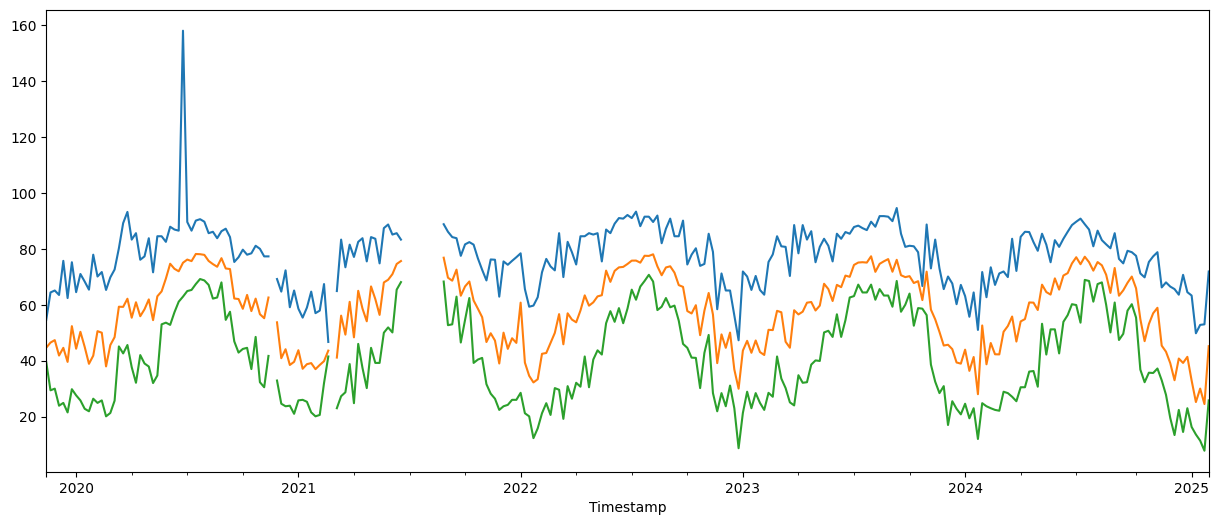

In [8]:
sensor = 'Back Fence'
#sensor = 'Raingauge'
df = splitDFDict[sensor]
metaDict = splitMetaDict[sensor]

attribute = 'Temperature ( F )'
timeBin = 'MS' # <https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects>
timeBin = 'W-MON'
#timeBin = 'D'
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling
yMean = df[attribute].resample(timeBin).mean()
yMax = df[attribute].resample(timeBin).max()
yMin = df[attribute].resample(timeBin).min()

# https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-visualization-with-python-3
yMax.plot(figsize=(15, 6))
yMean.plot(figsize=(15, 6))
yMin.plot(figsize=(15, 6))
plt.show()

In [9]:
df['2020-06-01':'2020-07-01'][attribute].describe()

count    7574.000000
mean       73.713203
std         7.286067
min        52.800000
25%        69.200000
50%        73.700000
75%        79.700000
max       158.000000
Name: Temperature ( F ), dtype: float64

In [10]:
df[df[attribute] > 150]

,Temperature ( F ),Humidity ( RH ),Dew Point ( F ),Heat Index ( F ),Barometric Pressure ( INHG ),file
Timestamp,,,,,,
2020-06-27 09:25:00-04:00,158.0,86.0,151.8,790.7,30.01,rite.v2/20200720.csv


#### Systematic outlier review: collect comparison

In order to understand the outliers, i compare the acurite measurements over the same period (max: 2024-06-16 07:05:00-04:00
min: 2023-10-23 13:20:00-04:00 ) for the sensors located at the rain gauge and the back fence. Looking at the extremes, a pair 
between the sensors occurred when the temperature was very stable. The average rolling standard deviation when outliers are 
measured is less than half the rolling standard deviation generally. I believe during times of steady temperature standard 
deviation gets into the noise of the precision of sensor.

Temperature outliers:

```
	            length	outliers	avg rolling std	 outliers rolling std	extremes
Raingauge+2h	67465	230	        1.461918	     0.500619	                2
Raingauge+4h	67465	172		    2.691296	     1.032814	                0
Raingauge+6h	67465	172		    3.861705	     1.451670	                0
Back Fence+2h	66019	297		   	1.198200	     0.487374	                1
Back Fence+4h	66019	206			2.212929	     0.736663	                2
Back Fence+6h	66019	106			3.188354	     1.116351	                1

```

So, i am adding another set of boolean columns to 

OK, first, get a truncated version of the back fence data and compare to the raingauge data. If both have extremes or outliers at the same time, that may indicate actual weather change.

In [11]:

outExamlDFDict = {}
outExamlDFDict['Raingauge'] = splitDFDict['Raingauge']

start = splitMetaDict['Raingauge']['earliest entry']
stop = splitMetaDict['Raingauge']['latest entry']
print (start, "to", stop,"\n")

outExamlDFDict['Back Fence'] = splitDFDict['Back Fence'][start : stop]

for s in outExamlDFDict:
    print (s,"length:",len(outExamlDFDict[s]))
    print ("max:",outExamlDFDict[s].index.max())
    print ("min:",outExamlDFDict[s].index.min(),"\n")

# I vaguely remember the awkward switching of sensors, so i am not surprised there was a gap. 

start = outExamlDFDict['Back Fence'].index.min().isoformat()
print ("Fixed: ",start, "to", stop,"\n")
outExamlDFDict['Raingauge'] = splitDFDict['Raingauge'][start : stop]

for s in outExamlDFDict:
    print (s,"length:",len(outExamlDFDict[s]))
    print ("max:",outExamlDFDict[s].index.max())
    print ("min:",outExamlDFDict[s].index.min(),"\n")


2023-10-21T10:30:00-04:00 to 2025-02-02T07:10:00-05:00 



ValueError: Both dates must have the same UTC offset

In [ ]:
# https://www.wunderground.com/cat6/extreme-short-duration-temperature-changes-us
# https://www.datacamp.com/tutorial/a-data-scientists-guide-to-signal-processing 

windowList = ["2h","4h","6h"] # The 2h rolling window seems reasonable looking at the average rolling standard deviations
attributeList = ['Temperature ( F )', 'Humidity ( RH )', 'Barometric Pressure ( INHG )']
minDict = {
      'Temperature ( F )' : 1, 
      'Humidity ( RH )' : 2 , 
      'Barometric Pressure ( INHG )' : 0.009
}

outExamSummaryDict = {}
outliersDFDict = {}
outExamSummaryDFDict = {}

for attribute in attributeList:
      min = minDict[attribute]
      for s in outExamlDFDict:
            df = outExamlDFDict[s]
            for w in windowList:
                  k = s+"+"+w
                  outliersDFDict[k] = rollingOutlierDetection(df[attribute],attribute,rollWindow=w,minDeviation=min)   
                  tempDF = outliersDFDict[k]    
                  outExamSummaryDict[k] = {
                        "length" : len(df[attribute]),
                        "outliers" : len(tempDF[tempDF["outlier"]]),
                        "avg rolling std" : tempDF["rolling std"].mean(),
                        "outliers rolling std" : tempDF[tempDF["outlier"]]["rolling std"].mean(),
                        "extremes" : len(tempDF[tempDF["extreme"]])
                  }
                  if 'outlier > min del' in list(tempDF.columns):
                        outExamSummaryDict[k]['outlier > min del'] = len(tempDF[tempDF['outlier > min del']])
                        outExamSummaryDict[k]['extreme > min del'] = len(tempDF[tempDF['extreme > min del']])


      outExamSummaryDFDict[attribute] = pd.DataFrame.from_dict(outExamSummaryDict,orient='index')
      print("\n",attribute,":\n\n",outExamSummaryDFDict[attribute],"\n")

In [ ]:
df.columns

#### Systematic outlier review: correlated extremes

So the extremes -- 4 sigma --  have one correlation. Examining the correlated extremes, what strikes me is that the weather was oddly unchanging. The temperature was barely changing, and the extreme is a tenth of a degree different from the rolling mean over 2 hrs. 

I think this means that to treat something as an outlier, not only does it need to be statistically significant, but it also needs to have an absolute difference from the rolling mean of over half a degree or something like that.

In [ ]:
df = outliersDFDict["Raingauge+2h"]
df[df['extreme']]

In [ ]:
df = outliersDFDict["Back Fence+2h"]
df[df['extreme']]

In [ ]:
outExamlDFDict["Raingauge"]["2023-11-11 20:00":"2023-11-12 04:00"].plot(figsize=(15, 6))
outExamlDFDict["Back Fence"]["2023-11-11 20:00":"2023-11-12 04:00"].plot(figsize=(15, 6))
plt.show()

#### Systematic outlier review: next...

In [ ]:
print(pd.DataFrame.from_dict(outExamSummaryDict,orient='index'))
bfDF = outliersDFDict["Back Fence+2h"]
rgDF = outliersDFDict["Raingauge+2h"]
print(rgDF.columns)

In [ ]:
rgDF["rolling std"].mean()
rgDF[rgDF["outlier"]]["rolling std"].mean()

pd.DataFrame.from_dict(outExamSummaryDict,orient='index')

In [ ]:
pd.DataFrame.from_dict(outExamSummaryDict,orient='index')

In [ ]:


bfDF[bfDF["outlier"]].plot(figsize=(15, 6))
#bfDF.plot(figsize=(15, 6))
rgDF[rgDF["outlier"]].plot(figsize=(15, 6))


plt.show()

<https://climate.rutgers.edu/stateclim/?section=menu&%20target=calculating_daily_mean_temperature>

### Convert units?

To convert millibars (mb) to inches of mercury (in Hg), divide the millibar reading by 33.86:
in Hg = mb / 33.86


Formula (32°F − 32) × 5/9 = 0°C